In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import copy
import time
import glob, os, sys

from helpers import get_sequences, iterate_minibatches, get_minibatches, check_game_roles_duplicates, \
                    process_moments
    
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import display, clear_output

import os

%matplotlib inline

from utilities import LoadData, PlotGame, make_video
from helpers import id_player, id_position, id_teams, get_player_trajectory, segment

# ---------------------------------------------------------
%load_ext autoreload
%autoreload 2

# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)

In [2]:
# we will use this fixed order as the role order
roles = ['F', 'G', 'C-F', 'G-F', 'F-G', 'C', 'F-C']
role_order = {'F': 0, 'G':4, 'C-F':1, 'G-F':3, 'F-G':3, 'C':2, 'F-C':1}
# its possible that F has similar role as G-f or F-G, we create empty slots to ensure meta order

In [29]:
%%time
game_id = '0021500463'
game_data = Data.load_game(game_id)
events_df = pd.DataFrame(game_data['events'])

Wall time: 21.6 s


In [30]:
print('events shape:', events_df.shape)
events_df.head(3)

events shape: (231, 8)


,end_time_left,home,moments,orig_events,playbyplay,quarter,start_time_left,visitor
0,702.31,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[0],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
1,686.28,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[1],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
2,668.42,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351444029, 692.25, 12.21, None, [[-1,...","[2, 3]",GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,692.25,"{'abbreviation': 'TOR', 'players': [{'playerid..."


show the plot, for the sake of comparison with processed moment later on

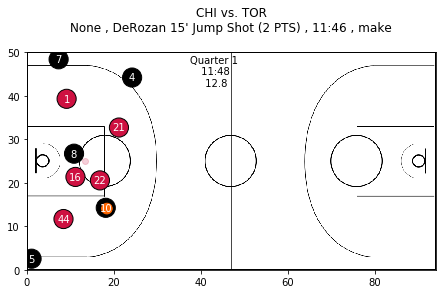

In [31]:
Plot = PlotGame(game_id, main_dir, game_dir)
Plot.load_moment2img(game_data, 0, 0, return_img=True)

### Let's just see the forward role model first, and ignore defending vs offending, use home vs visitor
### also ignore sequence length

In [32]:
id_role = id_position(events_df)
check_game_roles_duplicates(id_role)

0

In [33]:
events_df.loc[0].home['name']

'Chicago Bulls'

In [34]:
game_data['gamedate']

'2015-12-28'

In [35]:
len(events_df.loc[0,'moments'])

150

In [36]:
events_df['moments'].apply(lambda x: len(x)).values.min()

6

#### Pre-precoess input data

filter out actions except 1: Make, 2: Miss, 4: Rebound, 6:Personal Foul, 7:Violation

In [37]:
use_event = [1, 2, 4, 6, 7]
discard_event = [3, 5, 8, 9, 10, 12, 13, 18]
# events_df.loc[0, 'playbyplay'].to_dict('records')[0]

In [38]:
def filter_events(x, discard_event):
    etype = x['EVENTMSGTYPE'].values
    if len(set(etype).intersection(discard_event))!=0 or len(etype) ==0:
        # if the event contains discard events or if the event type is an empty list
        return False
    else:
        return True
    
events = events_df[events_df.playbyplay.apply(lambda x: filter_events(x, discard_event))].copy()
events.reset_index(drop=True, inplace=True)

In [39]:
events.shape

(134, 8)

Identify defending and offending runs (this is included in process_moments)

In [40]:
court_index = Data.load_csv('./meta_data/court_index.csv')
court_index = dict(zip(court_index.game_id, court_index.court_position))

without 24s shot clock seperation

In [41]:
# # %%time
# homeid = events.loc[0].home['teamid']
# awayid = events.loc[0].visitor['teamid']
# single_game = []

# # filter out seq length less than threshold
# len_th = 25
# n = 0    # record number that satisfies the threshold
# n_short = 0    # number that doesnt match
# for k, v in enumerate(events.moments.values):
#     result_i = process_moments(v, homeid, awayid, id_role, role_order, court_index, game_id)
#     if result_i == None:
#         continue
#     else:
#         pm, scs = result_i
#         if len(pm) >= len_th:
#             single_game.append(pm)
#             n += 1
#         else:
#             n_short += 1
# # dimensions extreme<3> x n_players<10> x (player_pos<2> + teamid_onehot<25> + ball<3>) = 900

split frames by shot clock 24s, re-order input according to role_order, extract trajectory

In [45]:
# %%time
homeid = events.loc[0].home['teamid']
awayid = events.loc[0].visitor['teamid']
single_game = []
sc = 24. # init 25s shot clock

# filter out seq length less than threshold, this has to be greater than 2
# otherwise, there might be duplicates appearing
len_th = 10
n = 0    # record number that satisfies the threshold
n_short = 0    # number that doesnt match
# s1 = 0    # index that divides the sequence, this usually happens for 24s shot clock
test = []
true = []
for k, v in enumerate(events.moments.values):
    result_i = process_moments(v, homeid, awayid, id_role, role_order, court_index, game_id)
    if result_i == None:
        continue
    else:
        s1 = 0 # index that divides the sequence, this usually happens for 24s shot clock
        pm, scs = result_i
#         print(len(pm), len(scs))
#         scs = [None, None, None, 24, 23,22,10, 24, None, None, 24, 11, 10,10, 10, 10,  9, 8, 7 ,None, None]
#         true.append(scs)
        for i in range(len(scs)-1):
            # sometimes there are None shot clock value
            if scs[i] != None and scs[i+1] == None:
                if len(scs[s1:i+1]) >= len_th:
                    single_game.append(pm[s1:i+1])
#                     print(pm[s1:i+1], 'A<<<<<<<<')
                    test.append(scs[s1:i+1])
                    n += 1
                else:
                    n_short += 1
                s1 = i+1
            elif scs[i] == None:
                s1 += 1
            elif scs[i+1] >= scs[i]:
                if len(scs[s1:i+1]) >= len_th:
                    single_game.append(pm[s1:i+1])
#                     print(pm[s1:i+1], 'B<<<<<<<<')
                    test.append(scs[s1:i+1])
                    n += 1
                else:
                    n_short += 1
                s1 = i+1
#             else:
#                 s1 += 1
        # grab the end piece
        if s1 != len(scs)-2:
            if len(scs[s1:]) >= len_th:
                single_game.append(pm[s1:])
#                 print(pm[s1:], scs[s1:], 'C<<<<<<<<')
                test.append(scs[s1:])
                n += 1
            else:
                n_short += 1
#         break
# dimensions extreme<3> x n_players<10> x (player_pos<2> + teamid_onehot<25> + ball<3>) = 900
# dimensions = extreme<3> x n_players<10> x player_pos<2> + teamid_onehot<4> + ball<3> = 

In [93]:
# subsample the sequence from 25 frames/sec to lower 
a = single_game[0].copy()
subsample_factor = 3
n_intervals = a.shape[0]//subsample_factor # number of subsampling intervals
left = a.shape[0]%subsample_factor # reminder
left

if left != 0:
    rs = [np.random.randint(0, subsample_factor) for _ in range(n_intervals)] + [np.random.randint(0, left)]
else:
    rs = [np.random.randint(0, subsample_factor) for _ in range(n_intervals)]
interval_ind = range(0, a.shape[0], subsample_factor)
rs_ind = np.array([rs[i] + interval_ind[i] for i in range(len(rs))])
# rs = [np.random.randint(0, extreme) for _ in range(10)]
# a

In [81]:
range(0, 7, 2)

range(0, 7, 2)

In [92]:
single_game[0].shape

(38, 67)

In [47]:
# single_game[0]

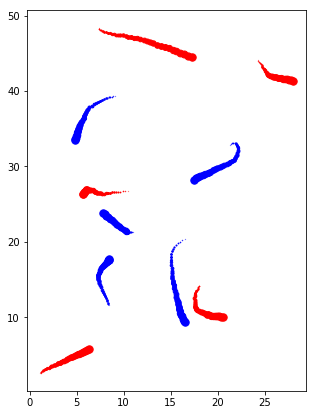

In [48]:
g = single_game[0]
plt.figure(figsize=(5,7))
c = ['b']*30 + ['r']*30
for i in range(0, 3*10*2, 2): # extreme=3, palyers=10, x,y=2
#     print(i)
    x_i, y_i = g[:, i], g[:, i+1]
    if sum(x_i) !=0 and sum(y_i) != 0:
#         plt.plot(x_i, y_i, c[i])
        for k in range(0, len(x_i)):
            plt.plot(x_i[k], y_i[k], linestyle="None", marker="o", markersize=k/5, color=c[i])

this roughly looks correct corresponding to the video created for the first moment of first event before 24sec shot clock reset

In [ ]:
print(n, n_short)

In [ ]:
homeid

In [ ]:
awayid

In [ ]:
print(len(single_game))

In [ ]:
single_game[0].shape

In [ ]:
# lets first predict role F (ignored the extreme)
game_target = [np.roll(i[:, :2], -1, axis=0) for i in single_game]

In [ ]:
single_game[0].shape

In [ ]:
game_target[0].shape

In [ ]:
single_game[1].shape

In [ ]:
single_game[2].shape

#### Create train and test set

In [ ]:
p = 0.8 # train percentage
divider = int(len(single_game)*p)
train_game, test_game = single_game[:divider], single_game[divider:]
train_target, test_target = game_target[:divider], game_target[divider:]

#### Build graph and starts training

In [ ]:
tf.reset_default_graph()
# use training start time as the unique naming
train_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
logs_path = './train_logs/'

# hyper-parameters
num_layers = 2
state_size = 128
batch_size = 64
dimx = 67
dimy = 2
n_epochs = 1000
learning_rate = 0.001

# lstm cells
lstm1 = tf.contrib.rnn.BasicLSTMCell(state_size, forget_bias=1.)
lstm1 = tf.nn.rnn_cell.DropoutWrapper(lstm1, output_keep_prob=0.8)

lstm2 = tf.contrib.rnn.BasicLSTMCell(state_size, forget_bias=1.)
lstm2 = tf.nn.rnn_cell.DropoutWrapper(lstm2, output_keep_prob=0.8)

lstm_cell = tf.contrib.rnn.MultiRNNCell([lstm1, lstm2])

# initial state
initial_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)

# input placeholders
h = tf.placeholder(tf.int32)
X = tf.placeholder(tf.float32, [batch_size, None, dimx], name = 'train_input')
Y = tf.placeholder(tf.float32, [batch_size, None, dimy], name = 'train_label')
# rnn structure
output, last_states = rnn_horizon(cell=lstm_cell, 
                                  initial_state=initial_state, 
                                  input_=X,
                                  batch_size=batch_size,
                                  seq_lengths=h,
                                  output_dim=dimy)
# output as the prediction
print('output shape, last_states', output.shape, last_states)
pred = output
print('label shape:{0:} | output prediction shape: {1:}'.format(Y.shape, pred.shape))

# tensorboard's graph visualization more convenient


# cost = tf.reduce_sum(tf.pow(pred - y, 2)) + regularization_cost
# optimizer = tf.train.AdamOptimizer().minimize(cost)


with tf.name_scope('MSEloss'):
    # loss (also add regularization on params)
    tv = tf.trainable_variables()
    # l2 weight loss
#     regularization_cost = tf.reduce_sum([tf.nn.l2_loss(v) for v in tv])
    # l1 loss
#     l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
#     regularization_cost = tf.contrib.layers.apply_regularization(l1_regularizer, tv)

#     loss = tf.losses.mean_squared_error(Y, pred) + regularization_cost
    # no weight loss
    loss = tf.losses.mean_squared_error(Y, pred)
with tf.name_scope('Adam'):
    # optimzier
    opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
# initialize variables
init = tf.global_variables_initializer()
# create a summary to monitor cost tensor
train_summary = tf.summary.scalar("TrainMSEloss", loss)
valid_summary = tf.summary.scalar("ValidMSEloss", loss)
# # Merge all summaries into a single op
# merged_summary_op = tf.summary.merge_all()


# session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# initializing the variables
sess.run(init)
# op to write logs to Tensorboard
train_writer = tf.summary.FileWriter(logs_path+'/train'+train_time, graph=tf.get_default_graph())
valid_writer = tf.summary.FileWriter(logs_path+'/valid'+train_time, graph=tf.get_default_graph())

# ===============================================================================================

# start training
printn = int(1e2)
# horizon = [2, 4, 8, 12, 16, 20, 25]
horizon = range(2, 50)
t_int = time.time()
train_step = 0
valid_step = 0
for k in horizon:
    # look-ahead horizon
#     seq_len = k + 1
    seq_len = k
    print('Horizon {0:} {1:}'.format(seq_len, '='*10))

    # train x
    train_x = copy.deepcopy([get_sequences(i, seq_len, dimx) for i in train_game])
    train_x = copy.deepcopy(np.concatenate(train_x, axis=0))
    print('train_x.shape:', train_x.shape)
    # train y
    train_y = copy.deepcopy([get_sequences(i, seq_len, dimy) for i in train_target])
    train_y = copy.deepcopy(np.concatenate(train_y, axis=0))
    print('train_y.shape:', train_y.shape)
    
    # valid x
    val_x = copy.deepcopy([get_sequences(i, seq_len, dimx) for i in test_game])
    val_x = copy.deepcopy(np.concatenate(val_x, axis=0))
    print('valid_x.shape:', val_x.shape)
    # valid y
    val_y = copy.deepcopy([get_sequences(i, seq_len, dimy) for i in test_target])
    val_y = copy.deepcopy(np.concatenate(val_y, axis=0))
    print('valid_y.shape:', val_y.shape)
    
    for epoch in range(n_epochs):
        epoch_loss =0.
        # number of train batches
        n_train_batch = train_x.shape[0]//batch_size
        t1 = time.time()
        for batch in iterate_minibatches(train_x, train_y, batch_size, shuffle=False):
            train_xi, train_yi = batch
            p, l, _, train_sum = sess.run([output, loss, opt, train_summary], 
                                        feed_dict={X: train_xi, Y: train_yi, h:seq_len})
            train_writer.add_summary(train_sum, train_step)
            epoch_loss += l/n_train_batch
            train_step += 1
        # print out info
        if epoch%printn ==0:
            # number of validation batches
            n_val_batch = val_x.shape[0]//batch_size
            t2 = time.time()
            valid_loss = 0
            for batch in iterate_minibatches(val_x, val_y, batch_size, shuffle=False):
                val_xi, val_yi = batch
                val_l, valid_sum = sess.run([loss, train_summary], 
                                            feed_dict={X: val_xi, Y: val_yi, h:seq_len})
                valid_writer.add_summary(valid_sum, valid_step)
                valid_loss += val_l/n_val_batch
                valid_step += printn
            print('Epoch {0:<4d} | loss: {1:<8.2f} | time took: {2:<.2f}s '
                  '| validation loss: {3:<8.2f}'.format(epoch, epoch_loss, (t2-t1), valid_loss))
                

t_end = time.time()
print('Total time took: {0:<.2f}hrs'.format((time.time()-t_int)/60/60))
# sess.close()
# # save model
# #Create a saver object which will save all the variables
# saver = tf.train.Saver()
# #save the graph
# saver.save(sess, save_path='./models/test_model')

### Check model on train set

In [ ]:
check_seq_len = 3

# use while loop to make sure the 
present = 0
while present == 0:
    check_ind = np.random.randint(0, len(train_game)-1)
    # check_ind = 0
#     print('check_id:', check_ind)
    input_x = copy.deepcopy(get_sequences(train_game[check_ind], check_seq_len, dimx))
#     print('input x shape >>>', input_x.shape)
    output_y = copy.deepcopy(get_sequences(train_target[check_ind], check_seq_len, dimy))
    if input_x.shape[0] >= batch_size:
        print('check_id:', check_ind)
        present += 1

pred = []
y_train = []
order_x = []
for batch in iterate_minibatches(input_x, output_y, batch_size, shuffle=False):
    input_xi, output_yi = batch
    p = sess.run([output], feed_dict={X: input_xi, h:check_seq_len})#, Y: train_yi, h:2})
    pred.append(p)
    order_x.append(input_xi)
    y_train.append(output_yi)
pred_train = np.array(pred).reshape(-1,2)
y_train = np.array(y_train).reshape(-1,2)
plt.figure(figsize=(15,8))
plt.plot(y_train[:,0], y_train[:,1], pred_train[:, 0], pred_train[:, 1])
plt.grid(True)

#### Check model on test set

In [ ]:
check_seq_len = 3

# use while loop to make sure the 
present = 0
while present == 0:
    check_ind = np.random.randint(0, len(test_game)-1)
    # check_ind = 0
#     print('check_id:', check_ind)
    input_x = copy.deepcopy(get_sequences(test_game[check_ind], check_seq_len, dimx))
#     print('input x shape >>>', input_x.shape)
    output_y = copy.deepcopy(get_sequences(test_target[check_ind], check_seq_len, dimy))
    if input_x.shape[0] >= batch_size:
        print('check_id:', check_ind)
        present += 1

pred = []
y_train = []
order_x = []
print(input_x.shape, output_y.shape)
for batch in iterate_minibatches(input_x, output_y, batch_size, shuffle=False):
    input_xi, output_yi = batch
    p = sess.run([output], feed_dict={X: input_xi, h:check_seq_len})#, Y: train_yi, h:2})
    pred.append(p)
    order_x.append(input_xi)
    y_train.append(output_yi)
pred_train = np.array(pred).reshape(-1,2)
y_train = np.array(y_train).reshape(-1,2)
plt.figure(figsize=(15,8))
plt.plot(y_train[:,0], y_train[:,1], pred_train[:, 0], pred_train[:, 1])
plt.grid(True)

#### Create video based off predictions

In [ ]:
# events.head()
# replace the true position with the predicted
events_pred = events.head(1).copy()
def replace_pos(x):
    for i in range(len(pred_train)):
#         print(x[i][5])
#         print(x[i][5][2][2:4], pred_train[i])
        x[i][5][2][2:4]=pred_train[i] 
events_pred = events_pred.moments.apply(lambda x: replace_pos(x))

In [ ]:
# save all moments for a specific events
Plot = PlotGame(game_id, main_dir, game_dir)
moments = range(len(pred_train))
event_number = 0
for i in moments:
    print(i, end='\r')
    Plot.load_pred_moment2img(game_data, event_number, i)
# PlotGame.load_pred_moment2img()

In [ ]:
#  so by comparing the position we know we are modelling the third position ind = 2
# order_x

In [ ]:
# prepare to save videos
event_dir = game_dir + 'game' + str(game_id) + '/' + 'predevent' + str(event_number) + '/'
video_name = event_dir + str(event_number) + '.mp4'
print(video_name)
images = glob.glob(event_dir + "*.png")
images = sorted(images, key=lambda x: int(x.split('.')[2].split('/')[-1][4:]))
# print(images)
# save to video
make_video(images, video_name, 15)

In [ ]:
pred_train.shape

In [ ]:
# len(events_pred.moments)

### To do:

    - 1) Regularize the lstm
    - 2) Figure out why there are blanks in the testing
    - 3) may consider to collect those left out from the process of creating batches
    - 4) related to 3), seq_len = 3 may create null batches 

    - Split data to defending and offending, as the model for e.g. forward role in deffending and offending should be pretty different. Remove particular events, like free-throw etc.
    
    - We can use the shot clock as an indicator of when the offending and defending switches.
    
    - The cameras oprate at 25 frames per second, so in order to learn realistic motions, either we sample the 25 frames, or extend the horizon to 50 for example or even longer(this might be too computationally heavy and model would probably drift a lot).
    
    - At the moment if we don't have defending or offending sepearted, at least we need to break down the sequences from the 24 secs shot clock, since it usually stands for a change in game state. (note: shot clock sometimes is None)
    
    - Add tensorboard visualization. Add validation performance (maybe, it would take longer). 
      tensorboard --logdir=./train_logs
      
    - Start thinking about 1) joint training 2) Hidden structure 3) Smooth learning

### Questions

    * After a team scored and they go back to get ready for defense, is the going back trajectory pretty much random?
    * Do player swap roles during the play? e.g. a forward swapped to a guard, is the forward roles a lot different from gaurds these day? (i.e. can you differentaite a player plaing forward from guard from the game) If yes, then the hidden structure learning/sequencing is necessary. 